<a href="https://colab.research.google.com/github/karnankit07/Restaurant_Recommendation-system/blob/main/Restaurant_Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Zomato_restaurant_Bangalore/zomato.csv"
df = pd.read_csv(path)

In [4]:
zomato_df = df.copy()
zomato_df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [8]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [9]:
zomato_df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


## Data preprocessing and Data Cleaning

We have to do the Data cleaning and Feature Engineering in this step.

Various operations are:

Deleting Unnecessary Columns, Removing the Duplicates, Remove the NaN values from the dataset, Changing the column names, Data Transformations, Data Cleaning, Adjust the column names

In [15]:
#Deleting Unnnecessary Columns
zomato_df=zomato_df.drop(['url','dish_liked','phone'],axis=1) #Dropping the column "dish_liked", "phone", "url" 

#Removing the Duplicates
zomato_df.duplicated().sum()
zomato_df.drop_duplicates(inplace=True)

#Remove the null values from the dataset
zomato_df.isnull().sum()
zomato_df.dropna(how='any',inplace=True)

#Changing the column names
zomato_df = zomato_df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})

#Some Transformations
zomato_df['cost'] = zomato_df['cost'].astype(str) #Changing the cost to string
zomato_df['cost'] = zomato_df['cost'].apply(lambda x: x.replace(',','.')) #Using lambda function to replace ',' from cost
zomato_df['cost'] = zomato_df['cost'].astype(float)
#Removing '/5' from Rates
zomato_df = zomato_df.loc[zomato_df.rate !='NEW']
zomato_df = zomato_df.loc[zomato_df.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato_df.rate = zomato_df.rate.apply(remove_slash).str.strip().astype('float')

# Adjust the column names
zomato_df.name = zomato_df.name.apply(lambda x:x.title())
zomato_df.online_order.replace(('Yes','No'),(True, False),inplace=True)
zomato_df.book_table.replace(('Yes','No'),(True, False),inplace=True)

## Computing Mean Rating
restaurants = list(zomato_df['name'].unique())
zomato_df['Mean Rating'] = 0

for i in range(len(restaurants)):
    zomato_df['Mean Rating'][zomato_df['name'] == restaurants[i]] = zomato_df['rate'][zomato_df['name'] == restaurants[i]].mean()
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato_df[['Mean Rating']] = scaler.fit_transform(zomato_df[['Mean Rating']]).round(2)

We have the cleaned data now

In [17]:
zomato_df.shape

(41237, 15)

In [18]:
zomato_df.isnull().sum()

address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
location        0
rest_type       0
cuisines        0
cost            0
reviews_list    0
menu_item       0
type            0
city            0
Mean Rating     0
dtype: int64

In [19]:
zomato_df.head(10)

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3.99
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,True,False,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,3.97
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,True,False,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,3.58
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,False,False,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.45
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,False,False,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,3.58
5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,True,False,3.8,286,Basavanagudi,Casual Dining,North Indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari,3.58
6,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel - Bar & Restaurant,False,False,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,3.32
7,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,True,True,4.6,2556,Banashankari,"Casual Dining, Cafe","Pizza, Cafe, Italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari,4.37
8,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,True,False,4.0,324,Banashankari,Cafe,"Cafe, Italian, Continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari,3.84
9,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,True,False,4.2,504,Banashankari,Cafe,"Cafe, Mexican, Italian, Momos, Beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari,4.10


# Text preprocessing and cleaning
We will be using the ‘Review’ and ‘Cuisines’ feature in order to create a recommender system. So we need to prepare and clean the text in those columns.

Operations performed: Lower Casing, Removal of Punctuations, Removal of Stopwords, Removal of URLs, Spelling correction

In [22]:
## Lower Casing
zomato_df["reviews_list"] = zomato_df["reviews_list"].str.lower()

## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_punctuation(text))

# Removal of Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_stopwords(text))

#Cleaning URL
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
zomato_df["reviews_list"] = zomato_df["reviews_list"].apply(lambda text: remove_urls(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
zomato_df[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
14692,rated 40 ratedn nice fine dine place tamil sty...,"Biryani, Chinese, North Indian, South Indian"
6409,rated 50 ratedn excellent food great service h...,Bengali
29882,rated 30 ratedn went buffet nice grand ambienc...,"North Indian, European, Thai"
11376,rated 40 ratedn famous shop bangalore city too...,"Desserts, Mithai"
18695,rated 10 ratedn misal much tastyni expected mi...,"Maharashtrian, Fast Food, Street Food, Sandwich"


# Exploratory data Analysis


1. Most famous restaurant chains in bangalore
2. Types of restaurant
3. Distribution of Restaurant Rating
4. Top 10 Rated Restaurants



Text(0.5, 0, 'Number of outlets')

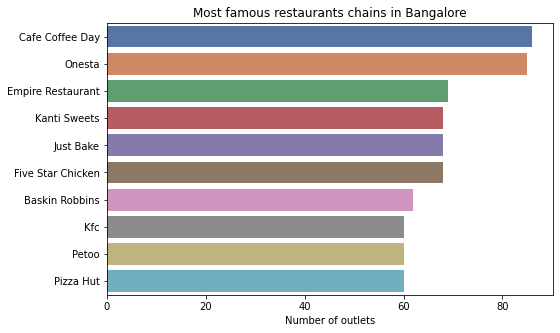

In [25]:
#Most Famous restaurant chains in Banglore
plt.figure(figsize=(8,5))
chains=zomato_df['name'].value_counts()[:10]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Most famous restaurants chains in Bangalore")
plt.xlabel("Number of outlets")

Text(0.5, 1.0, 'Types of Restaurant')

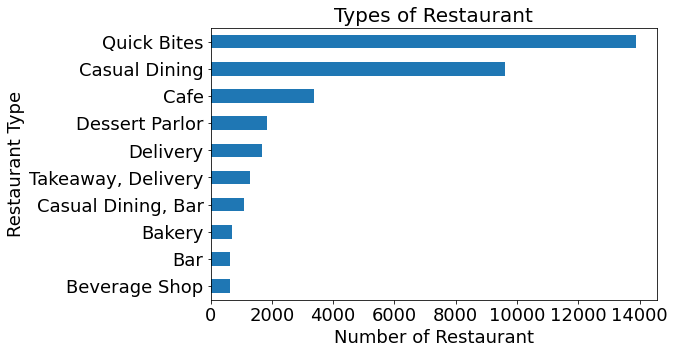

In [26]:
#Types of Restaurant
counts = zomato_df["rest_type"].value_counts()[:10] 
p = counts.sort_values().plot.barh(figsize=(8,5), fontsize=18) 
p.set_xlabel("Number of Restaurant",fontsize=18) 
p.set_ylabel("Restaurant Type",fontsize=18)
p.set_title("Types of Restaurant", fontsize=20)

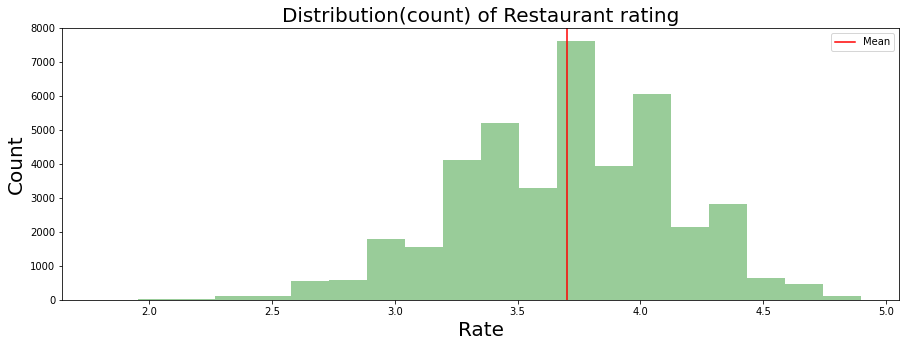

In [27]:
#Distribution of Restaurant Rating 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(zomato_df.rate,kde=False,color = 'g',ax =ax,bins=20);
ax.axvline(zomato_df.rate.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Rate',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

The above **Exploratory data analysis** charts were based on the most important columns of our data set. We can easily see the top restaurants based on Reviews, Votes and the most famous ones.

From the distribution of restaurants ratings, we can see that on average the restaurants in our dataset has a rating between 3.5 and 4.0. There are very few restaurants with a rating of less than 3.0

## EDA- Word Frequency Distribution

In [28]:
def get_top_words(column, top_nu_of_words, nu_of_word):
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

# Top 15-word frequency for cuisines

Text(0.5, 1.0, 'Word Couple Frequency for Cuisines')

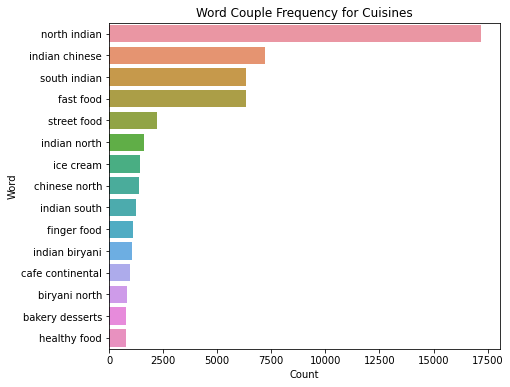

In [31]:
# Top 15 two word frequencies for Cuisines
lst = get_top_words(zomato_df['cuisines'], 15, (2,2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])
plt.figure(figsize=(7,6))
sns.barplot(data=df_words, x='Count', y='Word')
plt.title('Word Couple Frequency for Cuisines')

# CONTENT-BASE RECOMMENDER SYSTEM
**TF-IDF Matrix (Term Frequency — Inverse Document Frequency Matrix)**

TF-IDF method is used to quantify words and compute weights for them.In other words, representing each word (or couples of words etc.) with a number in order to use mathematics in our recommender system. Put simply, the higher the TF*IDF score (weight), the rarer and more important the term, and vice versa

Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.

In [33]:
df_percent = zomato_df.sample(frac=0.5)
df_percent.set_index('name', inplace=True)
indices = pd.Series(df_percent.index)
# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

Here, the tfidf_matrix is the matrix containing each word and its TF-IDF score with regard to each document, or item in this case. Also, stop words are simply words that add no significant value to our system, like ‘an’, ‘is’, ‘the’, and hence are ignored by the system.

In [34]:
#We want to calculate the cosine similarity of each item with every other item in the dataset. So we just pass the matrix as an argument.
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

Here we’ve calculated the cosine similarity of each item with every other item in the dataset

# Making a Recommendation

In [35]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    
    return df_new


Lets check our recommendation system!!

In [36]:
zomato_df.loc[(zomato_df.name == 'Marwa Restaurant')][:1]

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
931,"21, Ground Floor, B.H.C.S.L Layout, Stage 2, B...",Marwa Restaurant,True,True,3.5,551,Bannerghatta Road,Casual Dining,"North Indian, Chinese, Fast Food, BBQ",600.0,rated 50 ratedn disappointed decision shifting...,[],Delivery,Bannerghatta Road,3.19


In [37]:
recommend('Marwa Restaurant')

TOP 10 RESTAURANTS LIKE Marwa Restaurant WITH SIMILAR REVIEWS: 


,cuisines,Mean Rating,cost
Cinnamon,"North Indian, Asian, Continental",3.62,1.0
Altaf'S Chillies Restaurant,"North Indian, Chinese",3.61,500.0
Pallavi Restaurant,"Biryani, Chinese, Andhra",3.58,500.0
Fazzito Kitchen,North Indian,3.58,700.0
Sri Sai Mango Tree Restaurant,"North Indian, Biryani, Chinese",3.32,600.0
The Diner,"North Indian, Chinese, Andhra, Biryani",3.32,700.0
Desi Dhaba,"Chinese, North Indian",3.19,300.0
Desi Dhaba,"North Indian, Chinese, Rolls",3.19,300.0
Knight Ryders,"North Indian, Chinese",3.06,400.0
Food Point,North Indian,2.94,450.0
